In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [2]:
x = np.array([[0.5], [-0.3], [1.5], [0.2], [0.7], [0.5], [0.2], [-0.3], [0.34], [0.65]])
t = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
print(x.shape)
print(t.shape)

(10, 1)
(10,)


In [3]:
# def brownianbridge(xin, tin, n):
#     h = (tin[1]-tin[0])/n
#     tvec = tin[0] + (1+np.arange(n))*h
#     h12 = np.sqrt(h)
#     wincs = np.random.normal(scale=h12, size=n)
#     w = np.cumsum(wincs)

#     bridge = xin[0, :, None] + w
#     bridge -= ((tvec - tin[0])/(tin[1]-tin[0]))*(w[:, n - 1, None] + xin[0, :, None] - xin[1, :, None])
    
#     # concatenate the starting point to the bridge
#     # tvec.shape is (11, ) that is (numsubintervals + 1, )
#     # bridge.shape is (11, 2) that is (numsubintervals + 1, dim)
#     tvec = np.concatenate((tin[[0]], tvec)).T
#     bridge = np.concatenate((xin[0, :, None],bridge), axis = 1).T
#     return tvec, bridge

def brownianbridge(xin, tin, n):
    h = (tin[1] - tin[0]) / n
    tvec = tin[0] + (1 + np.arange(n)) * h
    h12 = np.sqrt(h)

    # W ~ N(0, sqrt(h)*g)
    wincs = np.random.multivariate_normal(mean = np.zeros(1), 
        cov = h * np.diag(np.square(np.full(1, 1.2))), 
        size = n)
    w = np.cumsum(wincs, axis = 0).T

    bridge = xin[0, :, None] + w
    bridge -= ((tvec - tin[0])/(tin[1]-tin[0]))*(w[:, n - 1, None] + xin[0, :, None] - xin[1, :, None])
    
    # concatenate the starting point to the bridge
    # tvec.shape is (11, ) that is (numsubintervals + 1, )
    # bridge.shape is (11, 2) that is (numsubintervals + 1, dim)
    tvec = np.concatenate((tin[[0]], tvec)).T
    bridge = np.concatenate((xin[0, :, None],bridge), axis = 1).T
    return tvec, bridge

In [4]:
# define drift function
def drift(x):
    f = 10*np.power(1. + np.power(x,2.0),0.25)
    return f

# # girsanov LOG likelihood
# def girsanov(path, dt):
#     b = drift(path)
#     int1 = np.dot(b[:-1], np.diff(path))
#     b2 = np.square(b)
#     int2 = np.sum(0.5*(b2[1:] + b2[:-1]))*dt
#     r = int1 - 0.5*int2
#     return r

# Girsanov likelihood is computed using
def girsanov(path, dt):
    gvec = np.full(1, 1.2)
    # path is of size (numsubintervals + 1, dim)
    # b is of size (numsubintervals + 1, dim)
    b = drift(path)
    u = np.dot(np.diag(np.power(gvec, -2)), b.T).T
    int1 = np.tensordot(u[:-1, :], np.diff(path, axis = 0))
    u2 = np.einsum('ij,ji->i', u.T, b)
    int2 = np.sum(0.5 * (u2[1:] + u2[:-1])) * (dt)
    r = int1 - 0.5 * int2
    return r


In [5]:
# MH sampler
def em(interval):
    burnin = 100
    n = 5
    h = (t[1]-t[0])/n
    samples = np.zeros(n)
    tout, xcur = brownianbridge(x[interval:interval+2],t[interval:interval+2],n)
    oldlik = girsanov(path=xcur, dt=h)
    arburn = np.zeros(burnin)
    for jj in range(burnin):
        _, prop = brownianbridge(x[interval:interval+2],t[interval:interval+2],n)
        proplik = girsanov(path=prop, dt=h)
        rho = np.exp(proplik - oldlik)
        if (rho > np.random.uniform()):
            xcur = prop
            oldlik = proplik
            arburn[jj] = 1

    _, prop = brownianbridge(x[interval:interval+2],t[interval:interval+2],n)
    proplik = girsanov(path=prop, dt=h)
    rho = np.exp(proplik - oldlik)
    if (rho > np.random.uniform()):
        xcur = prop
        oldlik = proplik
    return tout, xcur

In [6]:
def animate(i):
    n = 5
    dt = 1/n
    tout = np.arange(0.0, 10. + dt, dt)
    samples = np.zeros(tout.shape)
    for interval in range(x.shape[0] - 1):
        tnew, xnew = em(interval)
        samples[interval*n:(interval+1)*n+1] = np.squeeze(xnew)
    line.set_data(tout, samples)
    return (line,)

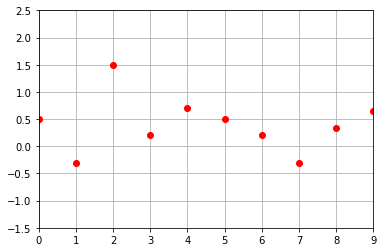

In [7]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( np.min(t), np.max(t)))
ax.set_ylim((-1.5, 2.5))
plt.plot(t, x, 'ro', lw=3)
line, = ax.plot([], [], lw=2)
ax.grid()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [8]:
anim = animation.FuncAnimation(fig, animate, frames=50, interval=200, blit=True)
anim

In [9]:
anim.save('diffbridge1d.gif', writer='imagemagick', fps=5)

In [10]:
Image(url='diffbridge1d.gif')

In [11]:
x = np.array([[0., 0.5], [0.5, -0.3], [1., 1.5], [1.5, .4], [2., .6]])
t = [0., 1., 2., 3., 4.]
gamma = np.array([.2,.25])

In [12]:
def brownianbridgeM(gvec, xin, tin, n):
    h = (tin[1]-tin[0])/n
    tvec = tin[0] + (1+np.arange(n))*h
    h12 = np.sqrt(h)
    wincs = np.random.multivariate_normal(mean=np.zeros(len(gvec)),
                                          cov=h*np.diag(np.square(gvec)),
                                          size=n)
    w = np.cumsum(wincs,axis=0).T
    bridge = xin[0,:,None] + w
    bridge -= ((tvec - tin[0])/(tin[1]-tin[0]))*(w[:,n-1,None] + xin[0,:,None] - xin[1,:,None])
    return tvec, bridge

In [13]:
# define drift function
def drift(x):
    f = np.zeros(x.shape)
    f[0,:] = x[1,:]
    f[1,:] = -np.sin(x[0,:])
    return f

In [14]:
# girsanov LOG likelihood
def girsanovM(gvec, path, dt):
    b = drift(path)
    u = np.dot(np.diag(np.power(gvec,-2)), b)
    int1 = np.tensordot(u[:,:-1], np.diff(path,axis=1))
    # int2 = np.tensordot(u, b)
    u2 = np.einsum('ij,ji->i',u.T,b)
    int2 = np.sum(0.5*(u2[1:] + u2[:-1]))*dt
    r = int1 - 0.5*int2
    return r

In [15]:
# MH sampler
def em2d(interval):
    burnin = 100
    n = 5
    h = (t[1]-t[0])/n
    tout, xcur = brownianbridgeM(gamma,x[interval:interval+2],t[interval:interval+2],n)
    oldlik = girsanovM(gvec=gamma, path=xcur, dt=h)
    arburn = np.zeros(burnin)
    for jj in range(burnin):
        # _, prop = brownianbridgeM(gamma,xaux,t,n)
        # prop += traj.T
        _, prop = brownianbridgeM(gamma,x[interval:interval+2],t[interval:interval+2],n)
        proplik = girsanovM(gvec=gamma, path=prop, dt=h)
        rho = proplik - oldlik
        if (rho >= np.log(np.random.uniform())):
            xcur = prop
            oldlik = proplik
            arburn[jj] = 1

#     print("Acceptance rate during burn-in:", np.mean(arburn))

    _, prop = brownianbridgeM(gamma,x[interval:interval+2],t[interval:interval+2],n)
    proplik = girsanovM(gvec=gamma, path=prop, dt=h)
    rho = proplik - oldlik
    if (rho >= np.log(np.random.uniform())):
        xcur = prop
        oldlik = proplik
#     _ = plt.plot(xcur[0,:],xcur[1,:], 'r')
    return xcur[0, :], xcur[1, :]

In [16]:
def animate2d(i):
    tout = np.arange(0.0, 4.0, 0.01)
    samples1 = np.zeros(tout.shape)
    samples2 = np.zeros(tout.shape)
    for interval in range(x.shape[0] - 1):
        samples1[interval*100:(interval+1)*100], samples2[interval*100:(interval+1)*100] = em2d(interval)
    line.set_data(samples1, samples2)
    return (line,)

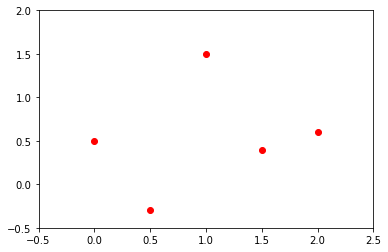

In [17]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim((-0.5, 2.5))
ax.set_ylim((-0.5, 2.))
plt.plot(x[:, 0], x[:, 1], 'ro')
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [18]:
anim = animation.FuncAnimation(fig, animate2d, frames=50, interval=200, blit=True)
anim

ValueError: could not broadcast input array from shape (5) into shape (100)

In [ ]:
anim.save('diffbridge2d.gif', writer='imagemagick', fps=5)

In [ ]:
Image(url='diffbridge2d.gif')